In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from linearmodels.panel import PanelOLS, compare, RandomEffects
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Bases de dados

In [2]:
df_agrup_munic_ano = pd.read_csv('../dados/tratados/agrupamento_empreend_acidentes_por_municipio_e_ano_sem_nulos.csv')

In [3]:
print(df_agrup_munic_ano.columns.tolist())
df_agrup_munic_ano.head()

['Código IBGE', 'ano', 'vlr_investimento', 'pop_beneficiada', 'num_total_empreendimentos', 'aux_emp_metro', 'aux_emp_metro_vlr_investimento', 'aux_emp_pavimentacao', 'aux_emp_pavimentacao_vlr_investimento', 'aux_emp_refrota', 'aux_emp_refrota_vlr_investimento', 'aux_emp_sinalizacao', 'aux_emp_sinalizacao_vlr_investimento', 'aux_emp_calcamento', 'aux_emp_calcamento_vlr_investimento', 'aux_emp_ciclovia', 'aux_emp_ciclovia_vlr_investimento', 'aux_emp_corredor', 'aux_emp_corredor_vlr_investimento', 'aux_emp_drenagem', 'aux_emp_drenagem_vlr_investimento', 'aux_emp_ferrovia', 'aux_emp_ferrovia_vlr_investimento', 'aux_emp_rapido', 'aux_emp_rapido_vlr_investimento', 'aux_emp_vlt', 'aux_emp_vlt_vlr_investimento', 'aux_emp_recapeamento', 'aux_emp_recapeamento_vlr_investimento', 'aux_emp_viaria', 'aux_emp_viaria_vlr_investimento', 'aux_emp_aero', 'aux_emp_aero_vlr_investimento', 'aux_emp_revitalizacao', 'aux_emp_revitalizacao_vlr_investimento', 'aux_emp_sarjeta', 'aux_emp_sarjeta_vlr_investimento

,Código IBGE,ano,vlr_investimento,pop_beneficiada,num_total_empreendimentos,aux_emp_metro,aux_emp_metro_vlr_investimento,aux_emp_pavimentacao,aux_emp_pavimentacao_vlr_investimento,aux_emp_refrota,...,taxa_mun_motociclista_feridos,taxa_mun_automovel_feridos,taxa_mun_veiculo_pesado_feridos,taxa_mun_onibus_feridos,taxa_mun_outros_feridos,Populacao,taxa_mun_triciclo_mortes,taxa_mun_caminhonete_mortes,taxa_mun_triciclo_feridos,taxa_mun_caminhonete_feridos
0,1100015.0,2011.0,1530000.00,1841.0,2,0,0.0,2,1530000.00,0,...,0.000000,0.000000,0.0,0.000000,0.000000,24228.0,0.0,0.0,0.0,0.0
1,1100023.0,2012.0,1787781.82,2087.0,2,0,0.0,0,0.00,0,...,0.177903,0.002156,0.0,0.000000,0.000000,92747.0,0.0,0.0,0.0,0.0
2,1100023.0,2014.0,36842105.26,43512.0,1,0,0.0,1,36842105.26,0,...,0.055415,0.000000,0.0,0.000972,0.000000,102860.0,0.0,0.0,0.0,0.0
3,1100031.0,2011.0,265850.00,306.0,1,0,0.0,1,265850.00,0,...,0.000000,0.000000,0.0,0.000000,0.000000,6221.0,0.0,0.0,0.0,0.0
4,1100049.0,2010.0,2821324.40,3343.0,3,0,0.0,2,2290724.40,0,...,0.006363,0.000000,0.0,0.000000,0.001273,78574.0,0.0,0.0,0.0,0.0


In [4]:
colunas_obrigatorias = ['total_mortes', 'total_feridos', 'Código IBGE', 'ano']
colunas_programa = list(df_agrup_munic_ano.filter(regex='^programa.*vlr_investimento$').columns) + ['vlr_investimento']

colunas_empreendimentos = df_agrup_munic_ano.filter(like='vlr_investimento').columns.tolist()
colunas_selecionadas = set(colunas_empreendimentos + colunas_obrigatorias) - set(colunas_programa)
df_agrup_munic_ano = df_agrup_munic_ano[colunas_selecionadas]
df_agrup_munic_ano.columns

/tmp/ipykernel_6382/1908303360.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_agrup_munic_ano = df_agrup_munic_ano[colunas_selecionadas]


Index(['aux_emp_recapeamento_vlr_investimento',
       'aux_emp_transporte_coletivo_vlr_investimento',
       'aux_emp_ciclovia_vlr_investimento', 'aux_emp_praca_vlr_investimento',
       'aux_emp_viaria_vlr_investimento', 'aux_emp_vlt_vlr_investimento',
       'aux_emp_calcadas_vlr_investimento', 'aux_emp_parque_vlr_investimento',
       'aux_emp_pavimentacao_vlr_investimento',
       'aux_emp_aero_vlr_investimento', 'total_feridos',
       'aux_emp_revitalizacao_vlr_investimento', 'total_mortes',
       'aux_emp_asfalto_vlr_investimento',
       'aux_emp_calcamento_vlr_investimento',
       'aux_emp_sarjeta_vlr_investimento', 'aux_emp_ponte_vlr_investimento',
       'aux_emp_refrota_vlr_investimento', 'aux_emp_drenagem_vlr_investimento',
       'aux_emp_corredor_vlr_investimento',
       'aux_emp_acessibilidade_vlr_investimento', 'Código IBGE',
       'aux_emp_sinalizacao_vlr_investimento', 'vlr_investimento_per_capita',
       'aux_emp_ferrovia_vlr_investimento',
       'aux_emp_ter

In [5]:
df_agrup_munic_ano.shape

(20700, 30)

## 

## Funções

In [6]:
def matrix_LI(matrix):
    """
    Seleciona colunas linearmente independentes de uma matriz de entrada.

    Esta função remove colunas com todos os valores zero, adiciona uma constante e, em seguida, 
    seleciona colunas linearmente independentes, começando com as duas primeiras colunas da matriz original.

    Parâmetros:
    matrix (pd.DataFrame): O DataFrame de entrada, contendo as colunas e um MultiIndex.

    Retorna:
    pd.DataFrame: Um novo DataFrame contendo apenas colunas linearmente independentes, 
    preservando o MultiIndex original.
    """
    # Removendo colunas com todos os valores zero
    matrix = matrix.loc[:, (matrix != 0).any(axis=0)]
    matrix = sm.add_constant(matrix).astype(float)

    # Selecionar as duas primeiras colunas da matriz original
    initial_columns = matrix.iloc[:, :2]
    remaining_matrix = matrix.iloc[:, 2:].values

    # Inicializa a matriz LI e lista de índices
    LI_matrix = initial_columns.values
    cols_li = initial_columns.columns.tolist()

    for i in range(remaining_matrix.shape[1]):
        # Adiciona uma coluna candidata
        nova_coluna = remaining_matrix[:, i].reshape(-1, 1)
        # Concatena a nova coluna à matriz de colunas LI
        temp_matrix = np.hstack([LI_matrix, nova_coluna])
        # Verifica o posto da nova matriz
        if np.linalg.matrix_rank(temp_matrix) > np.linalg.matrix_rank(LI_matrix):
            LI_matrix = temp_matrix
            cols_li.append(matrix.columns[i + 2])
        # Verificar se já temos o número máximo de colunas LI (igual ao número de linhas)
        if LI_matrix.shape[1] == LI_matrix.shape[0]:
            break

    # Convertendo de volta para DataFrame do Pandas com o MultiIndex original
    new_matrix = pd.DataFrame(LI_matrix, index=matrix.index, columns=cols_li)
    
    return new_matrix

In [7]:
def prepare_panel_data(df, selected_columns=[], check_rank=True):
    """
    Prepara os dados de um DataFrame para análise em painel.

    Parâmetros:
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados a serem preparados.
    selected_columns : list, opcional
        Lista de colunas selecionadas para a análise. Se não fornecida, todas as colunas numéricas serão utilizadas.
    check_rank : bool, opcional
        Flag para indicar se a verificação do posto da matriz deve ser realizada.

    Retornos:
    --------
    df_panel : pd.DataFrame
        DataFrame preparado para análise em painel, com as colunas independentes, dependentes e eixos do painel selecionados.
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes com uma constante adicionada.
    y1 : pd.Series
        Série contendo os valores da variável dependente 'total_mortes'.
    y2 : pd.Series
        Série contendo os valores da variável dependente 'total_feridos'.
    """

    # Fixos
    eixos_painel = ['Código IBGE', 'ano']
    y1_name = 'total_mortes'
    y2_name = 'total_feridos'

    if len(selected_columns) == 0:
        selected_columns = df.select_dtypes(include='number').columns.tolist()

    df_panel = df[pd.unique([y1_name, y2_name, *eixos_painel, *selected_columns]).tolist()].copy()
    df_panel['Código IBGE'] = df_panel['Código IBGE'].astype('category')
    df_panel.set_index(['Código IBGE', 'ano'], inplace=True)

    selected_columns = df_panel.columns
    x_columns_selected = selected_columns.drop([y1_name, y2_name]).tolist()

    X = df_panel[x_columns_selected]

    # Resolver problema de posto da matriz
    if check_rank:
        X = matrix_LI(X)
        selected_columns = [y1_name, y2_name, *X.columns.drop('const').tolist()]
        df_panel = df_panel[selected_columns]

    X = sm.add_constant(X).astype(float)
    y1 = df_panel[y1_name].astype(float)
    y2 = df_panel[y2_name].astype(float)

    return df_panel, X, y1, y2

In [8]:
def fit_panel_data_model(X, y, show_summary=True,drop_absorbed=True):
    """
    Ajusta um modelo de dados em painel usando o método de Mínimos Quadrados Ordinários (OLS).

    Parâmetros:
    ----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes.
    y : pd.Series
        Série contendo a variável dependente.
    show_summary : bool, opcional
        Flag para indicar se o resumo do modelo deve ser exibido. O padrão é True.

    Retornos:
    --------
    model : PanelOLS
        Modelo ajustado de dados em painel.
    """
    # Cria e ajusta o modelo de dados em painel com efeitos fixos para entidades
    model = PanelOLS(y, X, entity_effects=True,drop_absorbed=drop_absorbed)
    model = model.fit()
    
    # Exibe o resumo do modelo, se solicitado
    if show_summary:
        display(model.summary)
    
    return model



In [9]:
def teste_BP(X, y, y_name):
    """
    Realiza o teste de Breusch-Pagan para heterocedasticidade em um modelo de regressão OLS.

    Parâmetros:
    ----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes.
    y : pd.Series
        Série contendo a variável dependente.
    y_name : str
        Nome da variável dependente para ser exibido nos títulos dos resultados.

    """
    # Ajusta um modelo de regressão OLS
    model_ols = sm.OLS(y, X).fit()
    
    # Realiza o teste de Breusch-Pagan para verificar a heterocedasticidade dos resíduos
    LM, LM_pv, F, F_pv = het_breuschpagan(model_ols.resid, model_ols.model.exog)
    
    # Labels para os resultados do teste
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    
    # Exibe os resultados do teste
    print(f"\n\nBreusch-Pagan Test for Total {y_name}:")
    print(dict(zip(labels, (LM, LM_pv, F, F_pv))))
    
    # Verifica a hipótese de homoscedasticidade
    print(f"\nHipótese de Homoscedasticidade: {'Não' if ((LM_pv > .05) and (F_pv > .05)) else ''} Rejeitada")


In [10]:
def plot_residuos(model, y_name):
    """
    Plota a distribuição dos resíduos e a relação entre resíduos e valores ajustados para um modelo de regressão.

    Parâmetros:
    ----------
    model : PanelOLS
        Modelo de dados em painel ajustado.
    y_name : str
        Nome da variável dependente para ser exibido nos títulos dos gráficos.

    """
    # Plota a distribuição dos resíduos
    plt.hist(model.resids, bins=50, edgecolor='k')
    plt.title(f'Distribuição dos Resíduos - {y_name}')
    plt.xlabel('Resíduos')
    plt.ylabel('Frequência')
    plt.show()

    # Plota os resíduos versus os valores ajustados
    plt.scatter(model.fitted_values, model.resids, alpha=0.5)
    plt.title(f'Resíduos vs Valores Ajustados - {y_name}')
    plt.xlabel('Valores Ajustados')
    plt.ylabel('Resíduos')
    plt.show()


In [11]:
def effect_by_year(df, model, show_resid_graph=True):
    """
    Avalia o efeito dos resíduos do modelo ao longo dos anos e realiza o teste de Breusch-Pagan para cada ano.

    Parâmetros:
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados originais.
    model : PanelOLS
        Modelo de dados em painel ajustado.
    show_resid_graph : bool, opcional
        Flag para indicar se o gráfico dos resíduos médios ao longo do tempo deve ser exibido. O padrão é True.

    """
    df_aux = df.copy()
    
    # Adiciona os resíduos do modelo ao DataFrame auxiliar
    df_aux = df_aux.merge(model.resids, how='left', on=['Código IBGE', 'ano']).reset_index()
    df_aux.rename(columns={'residual': 'residuos'}, inplace=True)

    if show_resid_graph:
        # Calcula os resíduos médios por ano e por município
        residuos_por_ano = df_aux.groupby('ano')['residuos'].mean()
        residuos_por_municipio = df_aux.groupby('Código IBGE')['residuos'].mean()

        # Plota os resíduos médios ao longo do tempo
        plt.figure(figsize=(10, 6))
        plt.plot(residuos_por_ano, 'o-')
        plt.title('Resíduos Médios ao Longo do Tempo')
        plt.xlabel('Ano')
        plt.ylabel('Resíduos Médios')
        plt.show()

    # Realiza o teste de Breusch-Pagan para cada ano
    bp_results_ano = {}
    for year in df_aux['ano'].unique():
        df_year = df_aux[df_aux['ano'] == year]
        exog_year = df_year[df_year.columns.drop(['total_feridos', 'total_mortes'])]
        exog_year = sm.add_constant(exog_year)  # Adiciona uma constante
        _, lm_pvalue, _, f_pvalue = het_breuschpagan(df_year['residuos'], exog_year)
        bp_results_ano[year] = {'LM p-value': lm_pvalue, 'F p-value': f_pvalue}

    # Converte os resultados do teste de Breusch-Pagan para um DataFrame e exibe
    bp_results_ano_df = pd.DataFrame(bp_results_ano).T
    display(bp_results_ano_df)


In [12]:
def effect_by_city(df, model):
    """
    Avalia o efeito dos resíduos do modelo por município e realiza o teste de Breusch-Pagan para cada município.

    Parâmetros:
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados originais.
    model : PanelOLS
        Modelo de dados em painel ajustado.

    """
    # Cria um DataFrame auxiliar e adiciona os resíduos do modelo
    df_aux = df.copy().merge(model.resids, how='left', on=['Código IBGE', 'ano']).reset_index()
    df_aux.rename(columns={'residual': 'residuos'}, inplace=True)
    
    # Realiza o teste de Breusch-Pagan para cada município
    bp_results_municipio = {}
    for municipio in df_aux['Código IBGE'].unique():
        df_municipio = df_aux[df_aux['Código IBGE'] == municipio]
        if len(df_municipio) > 1:  # Certifica-se de que há mais de uma observação por município
            exog_municipio = df_municipio[df_municipio.columns.drop(['total_feridos', 'total_mortes'])]
            exog_municipio = sm.add_constant(exog_municipio)  # Adiciona uma constante
            _, lm_pvalue, _, f_pvalue = het_breuschpagan(df_municipio['residuos'], exog_municipio)
            bp_results_municipio[municipio] = {'LM p-value': lm_pvalue, 'F p-value': f_pvalue}

    # Converte os resultados do teste de Breusch-Pagan para um DataFrame e exibe a descrição estatística
    bp_results_municipio_df = pd.DataFrame(bp_results_municipio).T
    print(bp_results_municipio_df.describe())




In [13]:
# Calcular o VIF para cada variável independente
def VIF(X):
    X_vif = sm.add_constant(X)  # Adicionar constante
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    return vif_data

In [14]:
def compare_random_fixed_panel(X, y):
    """
    Compara os modelos de efeitos fixos e aleatórios para um conjunto de dados em painel.

    Parâmetros:
    ----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes.
    y : pd.Series
        Série contendo a variável dependente.

    """
    # Ajusta o modelo de efeitos fixos
    fe_model = PanelOLS(y, X, entity_effects=True).fit()
    
    # Ajusta o modelo de efeitos aleatórios
    re_model = RandomEffects(y, X).fit()
    
    # Compara os dois modelos
    comparison = compare({'Fixed Effects': fe_model, 'Random Effects': re_model})
    
    # Exibe a comparação dos modelos
    display(comparison)


In [15]:
def fit_random_effect(X, y, show_summary=True):
    # Modelo de Efeitos Aleatórios para Mortes
    fitted_model = RandomEffects(y, X).fit()
    if show_summary:
        fitted_model.summary
    return fitted_model

In [16]:
def salva_coeficientes(model):
    """
    Salva os coeficientes de um modelo estatístico em um arquivo CSV.

    Parâmetros:
    model (Statsmodels object): O modelo estatístico.

    Retorna:
    None
    """
    variavel_dependente = pd.DataFrame(model.summary.tables[0][0]).iloc[1]

    variavel_dependente = str(variavel_dependente.values[0])

    summary_df = pd.DataFrame(model.summary.tables[1])

    summary_df.columns = summary_df.iloc[0]
    summary_df = summary_df[1:]

    summary_df.rename(columns={summary_df.columns[0]: variavel_dependente}, inplace=True)

    if not os.path.exists('resultados_modelo'):
            os.makedirs('resultados_modelo')

    summary_df.to_csv(f'resultados_modelo/geral_{variavel_dependente}.csv', index=False)

## Seleciona variáveis para os dados em painel

**Eixos:**

eixo transversal = $Município$

eixo temporal = $ano$

**Variáveis dependentes:**

$y_1=total\_mortes$

$y_2=total\_feridos$

**Variáveis independentes:**

$X =$ variáveis numéricas excluindo colunas que tornam a matriz LD

Variáveis explicativas escolhidas, a princípio,  de forma arbitrária:

In [17]:
df_panel, X, y_mortes, y_feridos = prepare_panel_data(df_agrup_munic_ano.copy())
X

const  aux_emp_recapeamento_vlr_investimento  \
Código IBGE ano                                                    
1100015.0   2011.0    1.0                                   0.00   
1100023.0   2012.0    1.0                                   0.00   
            2014.0    1.0                                   0.00   
1100031.0   2011.0    1.0                                   0.00   
1100049.0   2010.0    1.0                              530600.00   
...                   ...                                    ...   
5300108.0   2015.0    1.0                                   0.00   
            2016.0    1.0                                   0.00   
            2017.0    1.0                                   0.00   
            2018.0    1.0                              652080.65   
            2019.0    1.0                                   0.00   

                    aux_emp_transporte_coletivo_vlr_investimento  \
Código IBGE ano                                                    
1100015.0   2011.0                                           0.0   
1100023.0   2012.0                                           0.0   
            2014.0                                           0.0   
1100031.0   2011.0                                           0.0   
1100049.0   2010.0                                           0.0   
...                                                          ...   
5300108.0   2015.0                                           0.0   
            2016.0                                           0.0   
            2017.0                                           0.0   
            2018.0                                           0.0   
            2019.0                                           0.0   

                    aux_emp_ciclovia_vlr_investimento  \
Código IBGE ano                                         
1100015.0   2011.0                               0.00   
1100023.0   2012.0                         1251042.30   
            2014.0                               0.00   
1100031.0   2011.0                               0.00   
1100049.0   2010.0                               0.00   
...                                               ...   
5300108.0   2015.0                               0.00   
            2016.0                               0.00   
            2017.0                          884006.08   
            2018.0                         1441471.26   
            2019.0                               0.00   

                    aux_emp_praca_vlr_investimento  \
Código IBGE ano                                      
1100015.0   2011.0                             0.0   
1100023.0   2012.0                             0.0   
            2014.0                             0.0   
1100031.0   2011.0                             0.0   
1100049.0   2010.0                             0.0   
...                                            ...   
5300108.0   2015.0                             0.0   
            2016.0                             0.0   
            2017.0                             0.0   
            2018.0                             0.0   
            2019.0                             0.0   

                    aux_emp_viaria_vlr_investimento  \
Código IBGE ano                                       
1100015.0   2011.0                              0.0   
1100023.0   2012.0                              0.0   
            2014.0                              0.0   
1100031.0   2011.0                              0.0   
1100049.0   2010.0                              0.0   
...                                             ...   
5300108.0   2015.0                              0.0   
            2016.0                              0.0   
            2017.0                              0.0   
            2018.0                              0.0   
            2019.0                              0.0   

                    aux_emp_vlt_vlr_investimento  \
Código IBGE ano                      

In [18]:
X.shape

(20700, 27)

In [19]:
set(df_agrup_munic_ano.columns) - set(X.columns)

{'Código IBGE', 'ano', 'total_feridos', 'total_mortes'}

## Efeitos Fixos

**Modelo simplificado**

$$y_{it} = \gamma_t + \beta'x_{it} + \epsilon_{it}$$

$$i = Município, \quad t = ano$$

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html


In [20]:
model_mortes = fit_panel_data_model(X, y_mortes)

/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
/home/oem/.loc

Dep. Variable:,total_mortes,R-squared:,0.3692
Estimator:,PanelOLS,R-squared (Between):,0.0729
No. Observations:,20700,R-squared (Within):,0.3692
Date:,"Wed, Jun 05 2024",R-squared (Overall):,0.1242
Time:,16:21:32,Log-likelihood,-7.897e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,347.40
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(26,15430)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,347.40


In [21]:
model_feridos = fit_panel_data_model(X, y_feridos)

/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
/home/oem/.loc

Dep. Variable:,total_feridos,R-squared:,0.0643
Estimator:,PanelOLS,R-squared (Between):,0.0198
No. Observations:,20700,R-squared (Within):,0.0643
Date:,"Wed, Jun 05 2024",R-squared (Overall):,0.0307
Time:,16:21:32,Log-likelihood,-1.215e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,40.805
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(26,15430)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,40.805


In [22]:
salva_coeficientes(model_mortes)

In [23]:
salva_coeficientes(model_feridos)

### Resíduos

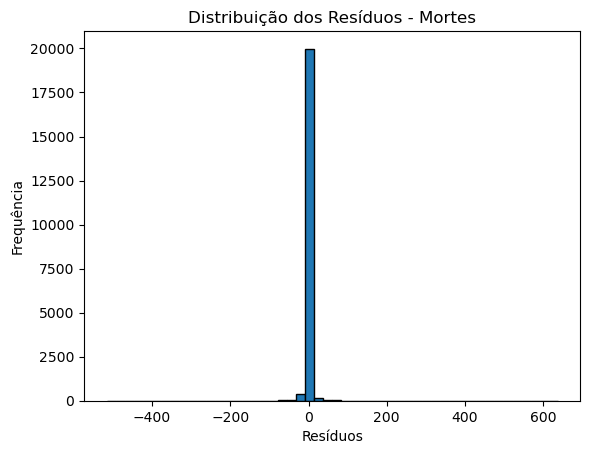

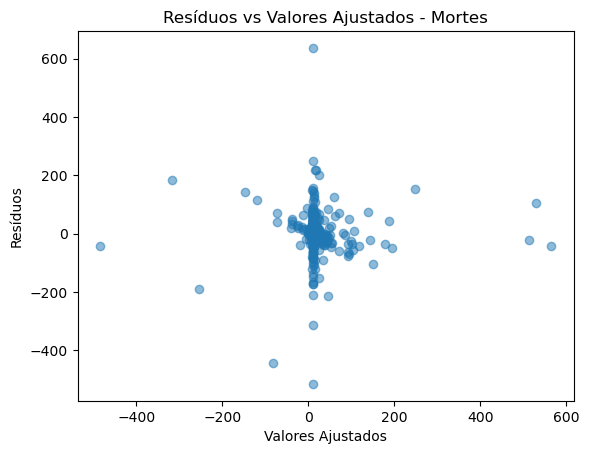

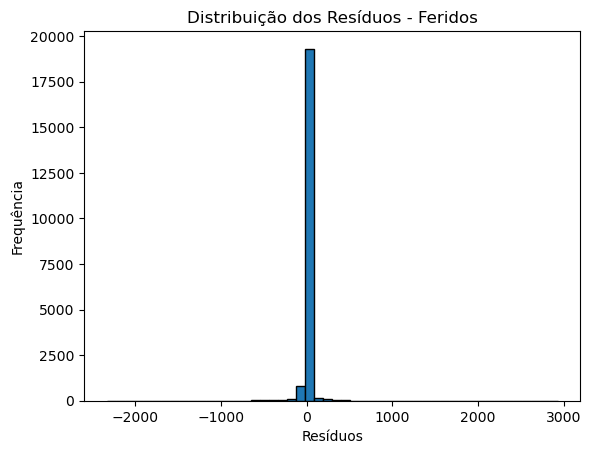

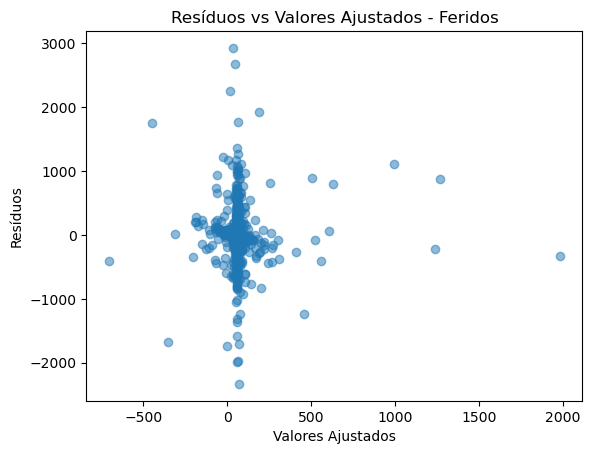

In [24]:
plot_residuos(model_mortes, 'Mortes')

plot_residuos(model_feridos, 'Feridos')

#### Teste de Breusch-Pagan para heteroscedasticidade

$H_0: Homoscedástico$

In [25]:
teste_BP(X, y_mortes, 'Mortes')
teste_BP(X, y_feridos, 'Feridos')



Breusch-Pagan Test for Total Mortes:
{'LM Statistic': 350.5356228666861, 'LM-Test p-value': 1.435007880154641e-58, 'F-Statistic': 13.696491535680485, 'F-Test p-value': 3.991201611732403e-59}

Hipótese de Homoscedasticidade:  Rejeitada


Breusch-Pagan Test for Total Feridos:
{'LM Statistic': 395.9176080435572, 'LM-Test p-value': 8.573413143916492e-68, 'F-Statistic': 15.50428013039707, 'F-Test p-value': 1.6201108673758418e-68}

Hipótese de Homoscedasticidade:  Rejeitada


### Resíduos por efeito de munícipio ou ano 

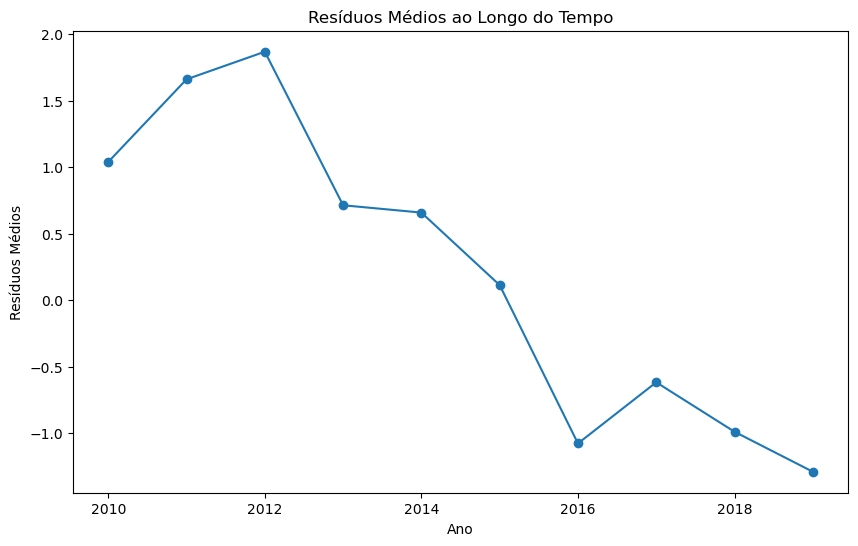

,LM p-value,F p-value
2011.0,1.252298e-237,0.000000e+00
2012.0,3.716279e-168,4.821067e-315
2014.0,3.014409e-236,0.000000e+00
2010.0,0.000000e+00,0.000000e+00
2013.0,0.000000e+00,0.000000e+00
2019.0,7.583587e-285,0.000000e+00
2015.0,1.096927e-242,0.000000e+00
2016.0,0.000000e+00,0.000000e+00
2017.0,4.144078e-285,0.000000e+00
2018.0,0.000000e+00,0.000000e+00


In [26]:
effect_by_year(df_panel, model_mortes)

In [27]:
# effect_by_city(df_panel, model_mortes)

### Regressão Quantilica

In [28]:
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

# Modelo de Regressão Quantílica para Mortes
quantile_model_mortes = QuantReg(y_mortes, X).fit(q=0.5)
quantile_model_mortes.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:           total_mortes   Pseudo R-squared:              0.08022
Model:                       QuantReg   Bandwidth:                      0.7477
Method:                 Least Squares   Sparsity:                        5.292
Date:                Wed, 05 Jun 2024   No. Observations:                20700
Time:                        16:21:33   Df Residuals:                    20673
                                        Df Model:                           26
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                        -3.536e-11   9.89e-07  -3.57e-05      1.000   -1.94e-06    1.94e-06
aux_emp_recapeamento_vlr_investimento         1.878e-06   1.15e-08    163.008      0.000    1.86e-06     1.9e-06
aux_emp_transporte_coletivo_vlr_investimento   3.89e-07   1.43e-09    271.818      0.000    3.86e-07    3.92e-07
aux_emp_ciclovia_vlr_investimento            -1.491e-06   1.12e-08   -133.094      0.000   -1.51e-06   -1.47e-06
aux_emp_praca_vlr_investimento                6.514e-07   2.03e-08     32.013      0.000    6.11e-07    6.91e-07
aux_emp_viaria_vlr_investimento                5.14e-07   3.79e-09    135.581      0.000    5.07e-07    5.21e-07
aux_emp_vlt_vlr_investimento                  3.174e-08    1.5e-09     21.144      0.000    2.88e-08    3.47e-08
aux_emp_calcadas_vlr_investimento             3.074e-07   2.87e-09    107.034      0.000    3.02e-07    3.13e-07
aux_emp_parque_vlr_investimento               4.193e-06   9.35e-08     44.845      0.000    4.01e-06    4.38e-06
aux_emp_pavimentacao_vlr_investimento         1.826e-06   3.22e-09    566.746      0.000    1.82e-06    1.83e-06
aux_emp_aero_vlr_investimento                 3.199e-07   1.29e-09    248.377      0.000    3.17e-07    3.22e-07
aux_emp_revitalizacao_vlr_investimento        2.477e-06    2.8e-08     88.464      0.000    2.42e-06    2.53e-06
aux_emp_asfalto_vlr_investimento              1.005e-06    2.1e-08     47.781      0.000    9.64e-07    1.05e-06
aux_emp_calcamento_vlr_investimento           1.987e-06   8.53e-08     23.287      0.000    1.82e-06    2.15e-06
aux_emp_sarjeta_vlr_investimento              2.258e-06   5.05e-08     44.700      0.000    2.16e-06    2.36e-06
aux_emp_ponte_vlr_investimento                8.032e-07   8.69e-09     92.405      0.000    7.86e-07     8.2e-07
aux_emp_refrota_vlr_investimento              2.811e-06   1.97e-08    143.034      0.000    2.77e-06    2.85e-06
aux_emp_drenagem_vlr_investimento            -4.873e-07   6.13e-09    -79.509      0.000   -4.99e-07   -4.75e-07
aux_emp_corredor_vlr_investimento               2.1e-08   1.28e-09     16.347      0.000    1.85e-08    2.35e-08
aux_emp_acessibilidade_vlr_investimento       -3.36e-07   2.11e-08    -15.954      0.000   -3.77e-07   -2.95e-07
aux_emp_sinalizacao_vlr_investimento          9.654e-07   1.53e-08     63.087      0.000    9.35e-07    9.95e-07
vlr_investimento_per_capita                  -5.193e-09      0.000  -2.83e-05      1.000      -0.000       0.000
aux_emp_ferrovia_vlr_investimento             2.938e-07   5.65e-10    519.788      0.000    2.93e-07    2.95e-07
aux_emp_terminal_vlr_investimento             1.625e-06   4.77e-09    340.505      0.000    1.62e-06    1.63e-06
aux_emp_rapido_vlr_investimento               2.124e-07   1.38e-09    154.244      0.000     2.1e-07    2.15e-07
aux_emp_metro_vlr_investimento               -5.466e-08    2.8e-10   -195.068      0.000   -5.52e-08   -5.41e-08
aux_emp_passeio_vlr_investimento           

In [29]:
# Modelo de Regressão Quantílica para Feridos
quantile_model_feridos = QuantReg(y_feridos, X).fit(q=0.5)
quantile_model_feridos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:          total_feridos   Pseudo R-squared:              0.07660
Model:                       QuantReg   Bandwidth:                     0.02611
Method:                 Least Squares   Sparsity:                       0.2869
Date:                Wed, 05 Jun 2024   No. Observations:                20700
Time:                        16:21:34   Df Residuals:                    20673
                                        Df Model:                           26
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                        -3.399e-10   5.36e-08     -0.006      0.995   -1.05e-07    1.05e-07
aux_emp_recapeamento_vlr_investimento         3.438e-06   6.25e-10   5504.364      0.000    3.44e-06    3.44e-06
aux_emp_transporte_coletivo_vlr_investimento  1.332e-06   7.76e-11   1.72e+04      0.000    1.33e-06    1.33e-06
aux_emp_ciclovia_vlr_investimento            -3.644e-07   6.07e-10   -599.893      0.000   -3.66e-07   -3.63e-07
aux_emp_praca_vlr_investimento                7.393e-06    1.1e-09   6700.604      0.000    7.39e-06    7.39e-06
aux_emp_viaria_vlr_investimento               1.065e-06   2.06e-10   5183.522      0.000    1.07e-06    1.07e-06
aux_emp_vlt_vlr_investimento                  1.757e-07   8.14e-11   2157.913      0.000    1.76e-07    1.76e-07
aux_emp_calcadas_vlr_investimento             2.285e-06   1.56e-10   1.47e+04      0.000    2.28e-06    2.28e-06
aux_emp_parque_vlr_investimento               1.429e-06   5.07e-09    281.777      0.000    1.42e-06    1.44e-06
aux_emp_pavimentacao_vlr_investimento         1.155e-07   1.75e-10    661.145      0.000    1.15e-07    1.16e-07
aux_emp_aero_vlr_investimento                 2.672e-06   6.98e-11   3.83e+04      0.000    2.67e-06    2.67e-06
aux_emp_revitalizacao_vlr_investimento        1.637e-05   1.52e-09   1.08e+04      0.000    1.64e-05    1.64e-05
aux_emp_asfalto_vlr_investimento              3.135e-07   1.14e-09    274.884      0.000    3.11e-07    3.16e-07
aux_emp_calcamento_vlr_investimento          -6.305e-08   4.63e-09    -13.630      0.000   -7.21e-08    -5.4e-08
aux_emp_sarjeta_vlr_investimento             -1.155e-07   2.74e-09    -42.167      0.000   -1.21e-07    -1.1e-07
aux_emp_ponte_vlr_investimento                1.953e-05   4.71e-10   4.14e+04      0.000    1.95e-05    1.95e-05
aux_emp_refrota_vlr_investimento              6.675e-05   1.07e-09   6.26e+04      0.000    6.68e-05    6.68e-05
aux_emp_drenagem_vlr_investimento              4.93e-08   3.32e-10    148.359      0.000    4.86e-08    4.99e-08
aux_emp_corredor_vlr_investimento             8.688e-07   6.97e-11   1.25e+04      0.000    8.69e-07    8.69e-07
aux_emp_acessibilidade_vlr_investimento       6.302e-06   1.14e-09   5519.201      0.000     6.3e-06     6.3e-06
aux_emp_sinalizacao_vlr_investimento          2.507e-07    8.3e-10    302.158      0.000    2.49e-07    2.52e-07
vlr_investimento_per_capita                  -4.493e-08   9.95e-06     -0.005      0.996   -1.96e-05    1.95e-05
aux_emp_ferrovia_vlr_investimento             2.353e-06   3.06e-11   7.68e+04      0.000    2.35e-06    2.35e-06
aux_emp_terminal_vlr_investimento             7.306e-06   2.59e-10   2.82e+04      0.000    7.31e-06    7.31e-06
aux_emp_rapido_vlr_investimento               2.791e-06   7.47e-11   3.74e+04      0.000    2.79e-06    2.79e-06
aux_emp_metro_vlr_investimento               -1.323e-07   1.52e-11  -8704.885      0.000   -1.32e-07   -1.32e-07
aux_emp_passeio_vlr_investimento           

Como o print apontou, há indícios de multicolinearidade ou outras questões atrapalhando as métricas

### VIF - correlação agrupada

Medida que verifica o grau de multicolinearidade em cada variável.

A estratégia é detectar variáveis com VIF muito grande (por exemplo >10) e eliminá-las do modelo

In [30]:
VIF(X)

,feature,VIF
0,const,1.485506
1,aux_emp_recapeamento_vlr_investimento,1.143005
2,aux_emp_transporte_coletivo_vlr_investimento,3.277251
3,aux_emp_ciclovia_vlr_investimento,2.090916
4,aux_emp_praca_vlr_investimento,1.000636
5,aux_emp_viaria_vlr_investimento,1.099046
6,aux_emp_vlt_vlr_investimento,1.782855
7,aux_emp_calcadas_vlr_investimento,1.430092
8,aux_emp_parque_vlr_investimento,1.017352
9,aux_emp_pavimentacao_vlr_investimento,1.870923


## Efeitos Aleatórios

**Modelo simplificado**

$$y_{it} = \beta'x_{it} + u_i + \epsilon_{it}$$

$$i = Município, \quad t = ano$$

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.RandomEffects.html

In [31]:
fit_random_effect(X, y_mortes, show_summary=True)

/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFr

Dep. Variable:,total_mortes,R-squared:,0.2326
Estimator:,RandomEffects,R-squared (Between):,0.1940
No. Observations:,20700,R-squared (Within):,0.2979
Date:,"Wed, Jun 05 2024",R-squared (Overall):,0.2173
Time:,16:21:35,Log-likelihood,-8.981e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,240.95
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(26,20673)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,251.52


In [32]:
fit_random_effect(X, y_feridos, show_summary=True)

/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFr

Dep. Variable:,total_feridos,R-squared:,0.0541
Estimator:,RandomEffects,R-squared (Between):,0.0798
No. Observations:,20700,R-squared (Within):,0.0295
Date:,"Wed, Jun 05 2024",R-squared (Overall):,0.0801
Time:,16:21:35,Log-likelihood,-1.304e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,45.512
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(26,20673)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,49.563


### Teste de Hausman

$H_0: $ os interceptos de cada $i$ não são correlacionados com $X_{it}$

a estratégia é que, se rejeitar $H_0$, então o modelo de efeitos fixos é mais adequado

In [33]:
compare_random_fixed_panel(X, y_mortes)

/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
/home/oem/.loc

,Fixed Effects,Random Effects
Dep. Variable,total_mortes,total_mortes
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.3692,0.2326
R-Squared (Within),0.3692,0.2979
R-Squared (Between),0.0729,0.1940
R-Squared (Overall),0.1242,0.2173
F-statistic,347.40,240.95
P-value (F-stat),0.0000,0.0000


In [34]:
compare_random_fixed_panel(X, y_feridos)


/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
/home/oem/.local/lib/python3.10/site-packages/linearmodels/panel/data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
/home/oem/.loc

,Fixed Effects,Random Effects
Dep. Variable,total_feridos,total_feridos
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.0643,0.0541
R-Squared (Within),0.0643,0.0295
R-Squared (Between),0.0198,0.0798
R-Squared (Overall),0.0307,0.0801
F-statistic,40.805,45.512
P-value (F-stat),0.0000,0.0000


Com p-valor = 0 em ambos os testes (para mortos e feridos), é adequado usar o modelo de efeito fixos para os dois

## Próximos passos

Agrupar por grupos de municipios